In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
from joblib import Parallel
from joblib import delayed
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from multiprocessing import cpu_count
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from sklearn.metrics import mean_squared_error as mse
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [28]:
df = pd.read_csv(".\sample.csv", index_col="Date", parse_dates=True)
df.index.freq = "W-SUN"
df.head()

,Branding,Sales,DisVol
Date,,,
2019-04-07 00:00:00+00:00,0,55036,58
2019-04-14 00:00:00+00:00,0,54924,58
2019-04-21 00:00:00+00:00,0,49364,56
2019-04-28 00:00:00+00:00,0,50059,57
2019-05-05 00:00:00+00:00,0,53516,59


In [29]:
print(df.shape)
print(df.columns)

(160, 3)
Index(['Branding', 'Sales', 'DisVol'], dtype='object')


### About the data

This is a sample sales data where the sales of an item is observed for 160 weeks. The sales is a time series data. Along with sales there is a distribution volume, which too changes with time. Hence the distribution volume is also a time series data. There is an additional Branding information which depicts if additional media branding was present for the item when the sales data was observed. 

There may be a relationship between the distirbution volume and the sales but it is not stated. 

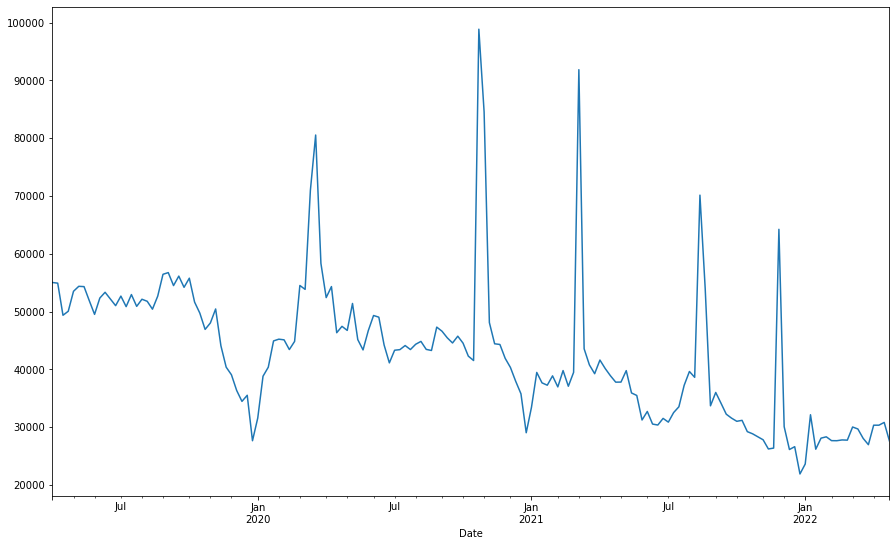

In [30]:
# let's take a look at the data
df["Sales"].plot(figsize=(15, 9));

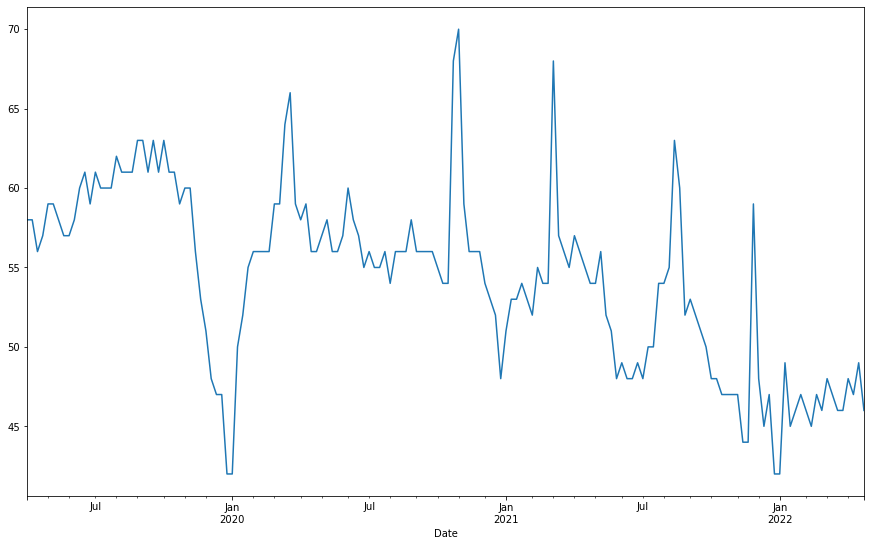

In [31]:
df["DisVol"].plot(figsize=(15, 9));

The plots for Sales and the Dsitribution Volume do have some similarities

## Concept 1: Moving Average

The moving average is a <b>time series data smoothing technique</b> where we take an average of a fixed number of consecutive data points. The averaging "moves" across time such that each point is sequentially included in the averaging while the oldest data point in the span of the average is removed.

This roughly represents the trend of the data.

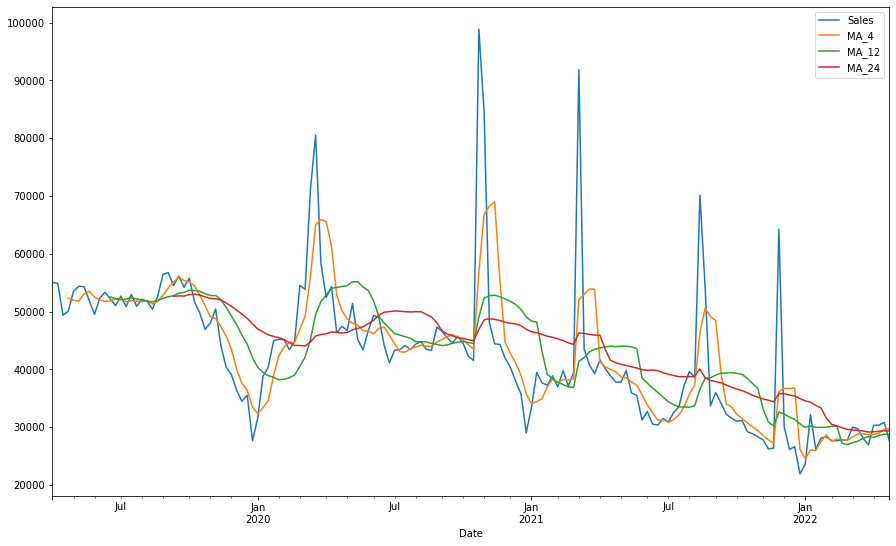

In [32]:
df_transform = df.copy()
# averaging over 1 month
df_transform["MA_4"] = df_transform["Sales"].rolling(4).mean()
# averaging over 3 months
df_transform["MA_12"] = df_transform["Sales"].rolling(12).mean()
# averaging over 6 months
df_transform["MA_24"] = df_transform["Sales"].rolling(24).mean()

# plot
ax = df_transform["Sales"].plot(figsize=(15,9), legend=True);
df_transform["MA_4"].plot(ax=ax, legend=True);
df_transform["MA_12"].plot(ax=ax, legend=True);
df_transform["MA_24"].plot(ax=ax, legend=True);

#### Observations:
1. Smaller periods have a poor smoothing effect - they capture more noise
2. Larger periods have a stronger smoothing effect - but they fail to capture the peak and valleys due to averaging
3. The weightage remains the same for each iteration

## Concept 2: Stationarity

If the statistical properties like mean, std. deviation, autocorrelation etc. remain constant for the data all throughout, the data is said to be stationary. If these properties do not remain constant, the data is said to be non-stationary. 

Most traditional tools for time series analysis require data to be stationary. A non-stationary data can be made stationary by differencing. We use the Dickey Fuller test to identify if our time series data is stationary

In [33]:
def adf_test(data):
    result = adfuller(data)
    labels = ["ADF Test Stats", "p-value", "# lags", "# obs"]
    out = pd.Series(result[:4], index=labels)
    for k,v in result[4].items():
        out[k] = v
    print(out.to_string())
    if result[1] < 0.05:
        print("Reject Null Hypothesis")
        print("Data is stationary")
    else:
        print("Failed to reject Null Hypothesis")
        print("Data is not stationary")

In [34]:
# test for stationarity 
adf_test(df["Sales"])

ADF Test Stats     -3.505906
p-value             0.007837
# lags              2.000000
# obs             157.000000
1%                 -3.472703
5%                 -2.880132
10%                -2.576683
Reject Null Hypothesis
Data is stationary


In [35]:
adf_test(df["DisVol"])

ADF Test Stats     -2.399143
p-value             0.141978
# lags              2.000000
# obs             157.000000
1%                 -3.472703
5%                 -2.880132
10%                -2.576683
Failed to reject Null Hypothesis
Data is not stationary


In [36]:
# differencing to make DisVol stationary
df_stat = df.diff().dropna()
print(adf_test(df_stat["Sales"]))
print(adf_test(df_stat["DisVol"]))

ADF Test Stats   -8.967694e+00
p-value           7.907065e-15
# lags            3.000000e+00
# obs             1.550000e+02
1%               -3.473259e+00
5%               -2.880374e+00
10%              -2.576812e+00
Reject Null Hypothesis
Data is stationary
None
ADF Test Stats   -1.230986e+01
p-value           7.132373e-23
# lags            1.000000e+00
# obs             1.570000e+02
1%               -3.472703e+00
5%               -2.880132e+00
10%              -2.576683e+00
Reject Null Hypothesis
Data is stationary
None


The data is now stationary, but we lost one row and the data is now differenced by 1 step

## Concept 3: Exponential Smoothing

Exponential smoothing is a time series forecasting technique for univariate data. It is generally compared to the ARMA family of forecasting and analysis models. In this technique, predictions are generated as a weighted linear sum of the recent past observations (called "lags"). The weightage however <b>decreases exponentially for past observations</b>. This method is sometimes also known as the ETS model - as Error(residual), Trend and Seasonality are explicitly modeled.  

There are 3 types of exponential smoothing - 
1. Simple Exponential Smoothing - Here we assume that the data is stationary, it does not have a trend or seasonality. This technique requires a single parameter <b>alpha</b> which denotes the rate of exponential decay of the weights. 

2. Double Exponential Smoothing - This is applied when the data has a trend. The trend can be of two types - "additive" or "multiplicative". To make sure that the trend does not keep constantly increasing or decreasing for future forecasts, a damping parameter is applied that can flatten the trend at some point in future. Hence this technqiue has the following parameters:
* alpha: smoothing factor of the weights
* beta: smoothing factor of the trend
* trend type: additive or multiplicative
* damping type: additive or multiplicative
* phi: damping coefficient

3. Triple Exponential Smoothing - This is applied when the data has a trend as well as seasonality. Seasonality can also be modeled as an additive or multiplicative process. To ensure that the seasonlity is modeled correctly, the number of time steps in a seasonal period must be specified. Along with the parameters in a double exponential smoothing, we have three more parameters here:
* gamma: smoothing factor of the seasonality
* seasonality type: additive or multiplicative
* period: time steps in a seasonal period

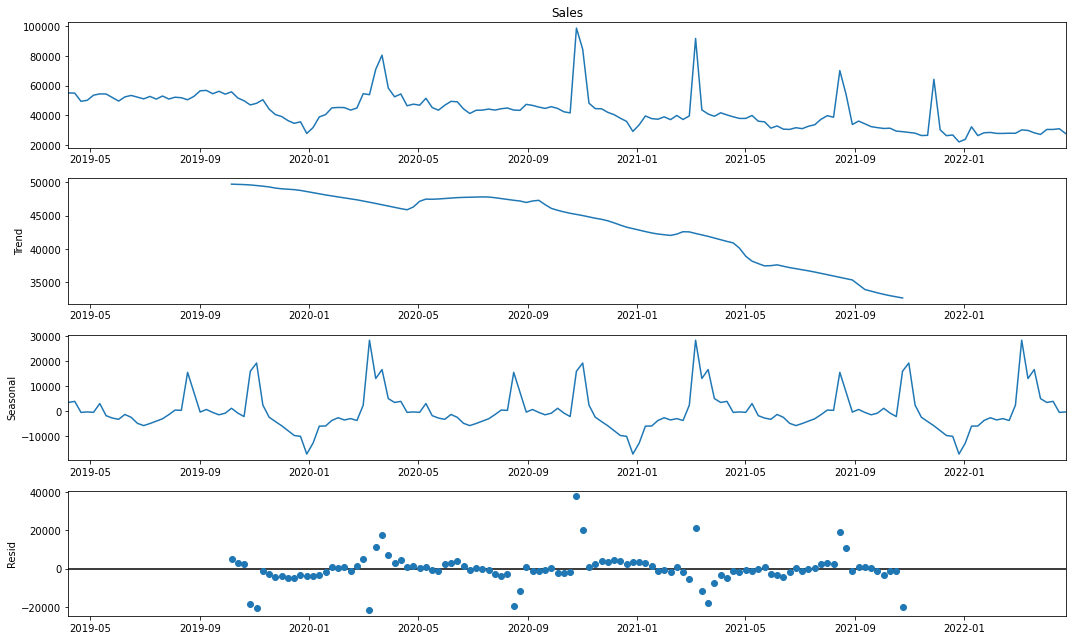

In [37]:
# we can run seasonal decompose to take a look at the ETS plots
# for Sales
rcParams["figure.figsize"] = 15,9
results = seasonal_decompose(df["Sales"])
results.plot();

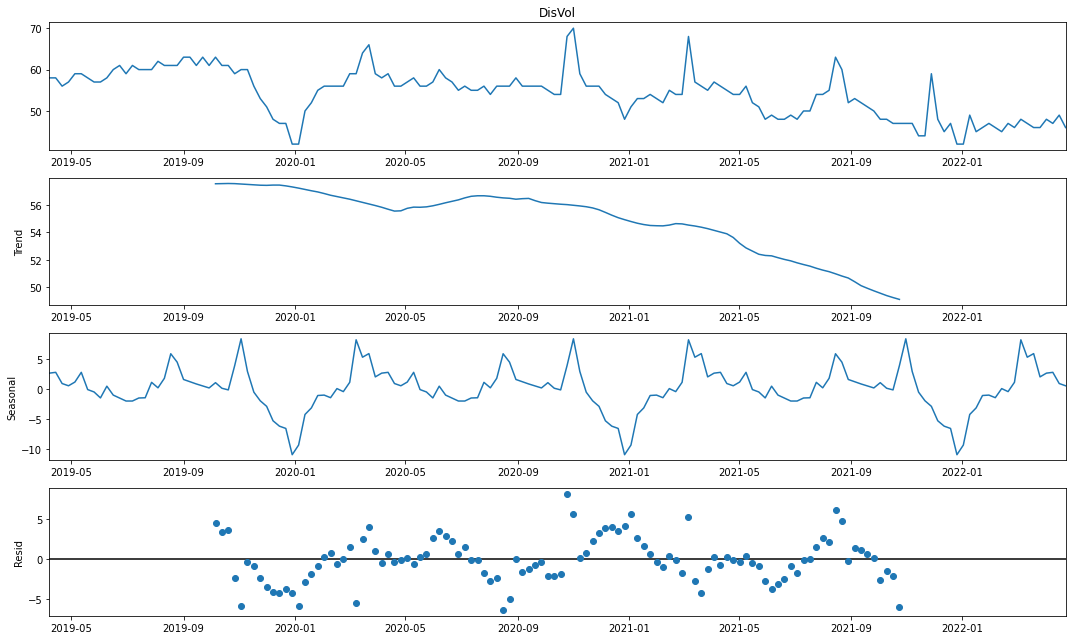

In [38]:
# for Distribution Volume
rcParams["figure.figsize"] = 15,9
results = seasonal_decompose(df["DisVol"])
results.plot();

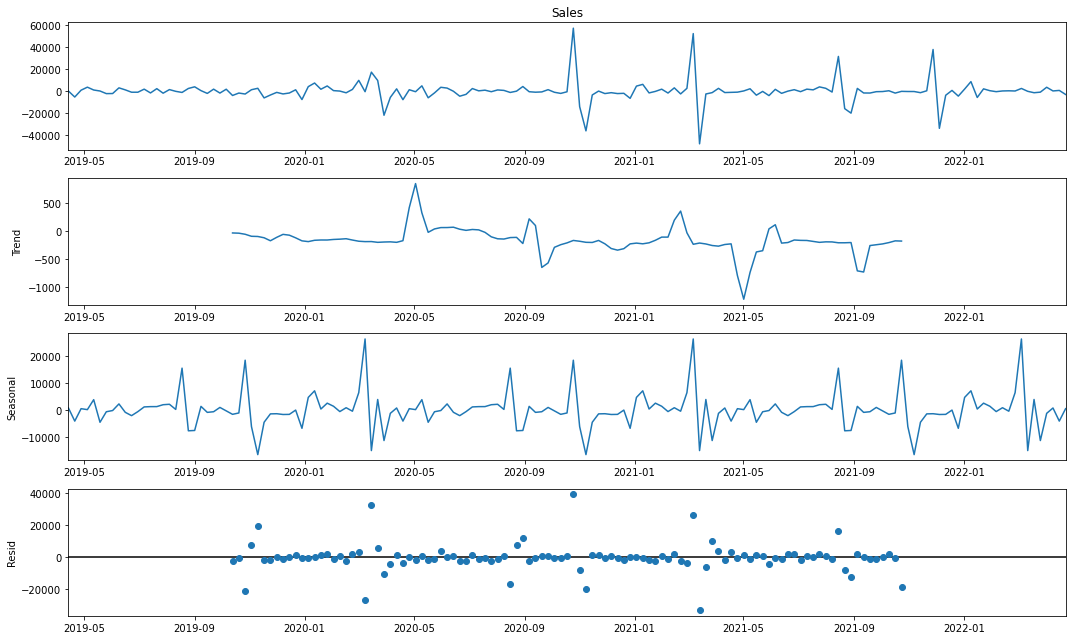

In [39]:
# the ETS for stationary data
rcParams["figure.figsize"] = 15,9
results = seasonal_decompose(df_stat["Sales"])
results.plot();

In [40]:
# let's split the data into test and train set
def train_test_split(data, n):
    train_data = data[:-n]
    test_data = data[-n:]
    return train_data, test_data

In [41]:
train, test = train_test_split(df, 12)
train_stat, test_stat = train_test_split(df_stat, 12)

We can now define a grid search technique to find the best performing parameters to fit an Exponential Smoothing model. While this may take some time to finish, it returns the parameters with the best scores. I have used the scoring technique of rmse to find the best model. 

In [44]:
## define the configs
## these are the different config options that we want our grid search to evaluate
t_params = ["add", "mul", None]
s_params = ["add", "mul", None]
s_period_params = list(np.arange(4, 50, 4)) + [None]
damped = [True, False]
use_boxcox = [True, False]
r_bias = [True, False]

# generate all the possible combinations
model_config_list = list(itertools.product(t_params, s_params, s_period_params, damped, use_boxcox, r_bias))
print("Number of model configurations to evaluate: ", len(model_config_list))

# applying custom grid search method to find the best hyper parameters
def get_rmse(true, pred):
    try:
        x = np.sqrt(mse(true, pred))
        return x
    except Exception as e:
        return -100

def fit_predict(train_data, test_data, model_cfg):
    trend, seasonal, seasonal_periods, damped, use_boxcox, remove_bias = model_cfg
    try:
        model = ExponentialSmoothing(train_data["Sales"], trend=trend, damped_trend=damped, seasonal=seasonal, seasonal_periods=seasonal_periods, use_boxcox=use_boxcox)
        model = model.fit(optimized=True, remove_bias=remove_bias)
        prediction = model.forecast(len(test_data))
        return get_rmse(test_data["Sales"], prediction)
    except Exception as e:
        print("Some error occured!!!")
        print(e)


def score_model(train_data, test_data, model_cfg):
    key = str(model_cfg)
    rmse_score = fit_predict(train_data, test_data, model_cfg)
    return (key, rmse_score)


def grid_search(train_data, test_data, cfg_list, parallel=False):
    scores = None
    if parallel:
        print("Parallel processing...")
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(train_data, test_data, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        print("Serial processing...")
        scores = [score_model(train_data, test_data, cfg) for cfg in cfg_list]
    
    # score may be none so filter that out
    scores = [x for x in scores if x[1] and x[1] != -100]
    # sort by the scores - min is the best
    scores.sort(key = lambda x: x[1])
    
    return scores

# applying grid search for the sales data 
scores = grid_search(train_data = train, test_data=test, cfg_list = model_config_list, parallel=False)

Number of model configurations to evaluate:  936
Serial processing...
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
So

Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component
Some error occured!!!
Can only dampen the trend component


Since the scores are sorted, we can take a look at the best model found

In [45]:
print(scores[0])

("(None, 'mul', 4, False, True, True)", 1286.7199667454581)


We can now fit the final model with this set of parameters and then forecast

<AxesSubplot:xlabel='Date'>

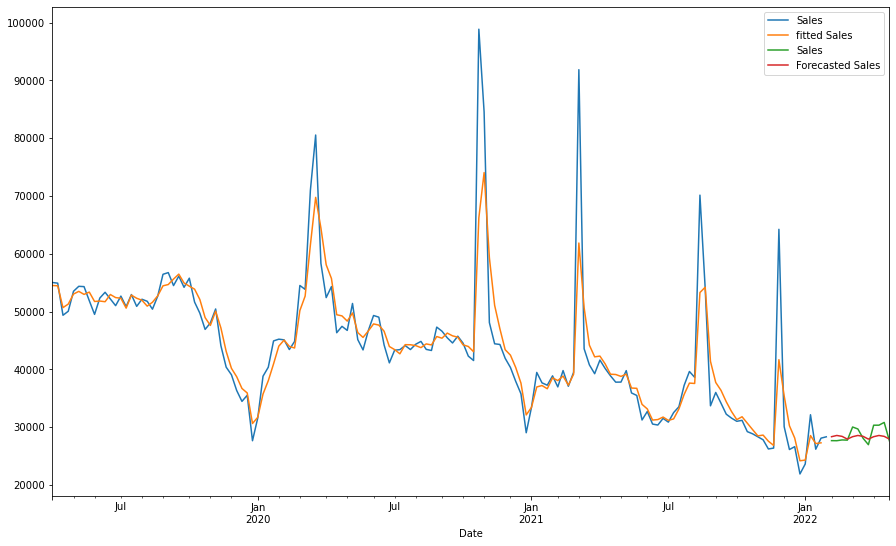

In [46]:
es_model = ExponentialSmoothing(train["Sales"], trend=None, seasonal="mul", seasonal_periods=4, damped_trend=False, use_boxcox=True).fit(optimized=True, remove_bias=True)
forecast = es_model.forecast(len(test))

ax = train["Sales"].plot(legend=True);
# df.plot(ax=ax)
es_model.fittedvalues.shift(-1).rename("fitted Sales").plot(ax=ax, legend=True)
test["Sales"].plot(ax=ax, legend=True);
forecast.rename("Forecasted Sales").plot(ax=ax, legend=True)

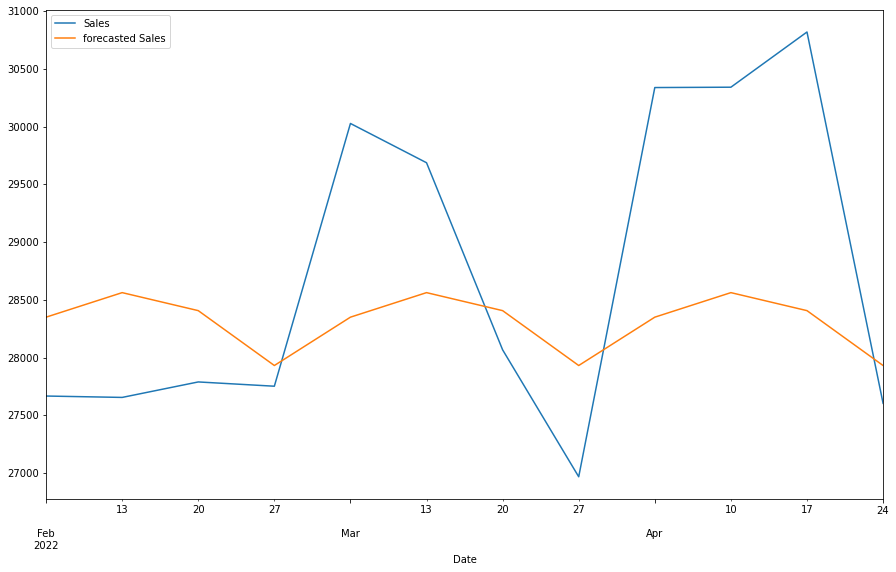

In [47]:
ax = test["Sales"].plot(legend=True);
forecast.rename("forecasted Sales").plot(ax=ax, legend=True);

In [48]:
print(train["Sales"].mean())
print(forecast.mean())

43771.32432432433
28312.46576798589


## (S)AR(I)MA(X)

A very widely used statistical method for time series analysis is ARIMA. ARIMA is an acronym for Auto Regressive Integrated Moving Average.  

It has 3 parameters - p, d and q

p - The number of lag observations included in the model (also known as the lag order)

d - The number of times the raw observations are differenced to make the data stationary

q - The size of the moving average window (also known as the order of the moving average)

Another variation of the model can take into consideration the seasonal effects (SARIMA) along with external factors that influence the time series data (SARIMAX). SARIMA model itself has the p,q,d params along with the seasonal period parameter. 

Here I have used the auto arima method that can evaluate the best parameters itself, based on the AIC (Akaike information criterion). I have also used exogenous variables, which are additional features present in the data. This has significantly improved the results. 

In [49]:
# apply auto arima to identify the best values of p, d and q
arima_model =  auto_arima(df["Sales"], X=df[["DisVol", "Branding"]], start_p=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, seasonal=True, m=4,  
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50)

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  160
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 4)   Log Likelihood               -1550.625
Date:                             Tue, 30 Aug 2022   AIC                           3117.250
Time:                                     14:27:06   BIC                           3141.649
Sample:                                 04-07-2019   HQIC                          3127.160
                                      - 04-24-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DisVol      2150.7946     58.276     36.907      0.000    2036.575    2265.014
Branding   -2418.2745   7408.724     -0.326      0.744   -1.69e+04    1.21e+04
ar.L1          0.9871      0.026     38.223      0.000       0.936       1.038
ma.L1         -0.6077      0.078     -7.760      0.000      -0.761      -0.454
ma.L2         -0.1008      0.089     -1.134      0.257      -0.275       0.073
ar.S.L4        0.1975      0.100      1.985      0.047       0.002       0.393
ma.S.L4       -0.9452      0.100     -9.410      0.000      -1.142      -0.748
sigma2      2.937e+07      0.657   4.47e+07      0.000    2.94e+07    2.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.68   Jarque-Bera (JB):               480.25
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.55
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.59e+23. Standard errors may be unstable.
"""

In [50]:
model = SARIMAX(train["Sales"], exog=train[["DisVol", "Branding"]], order=(1, 0, 2), seasonal_order=(1, 1, [1], 4)).fit()

In [51]:
start = len(train)
end = len(train) + len(test) - 1
forecasts = model.predict(start=start, end=end, exog=test[["DisVol", "Branding"]], typ='levels').rename("ARIMA forecasts")

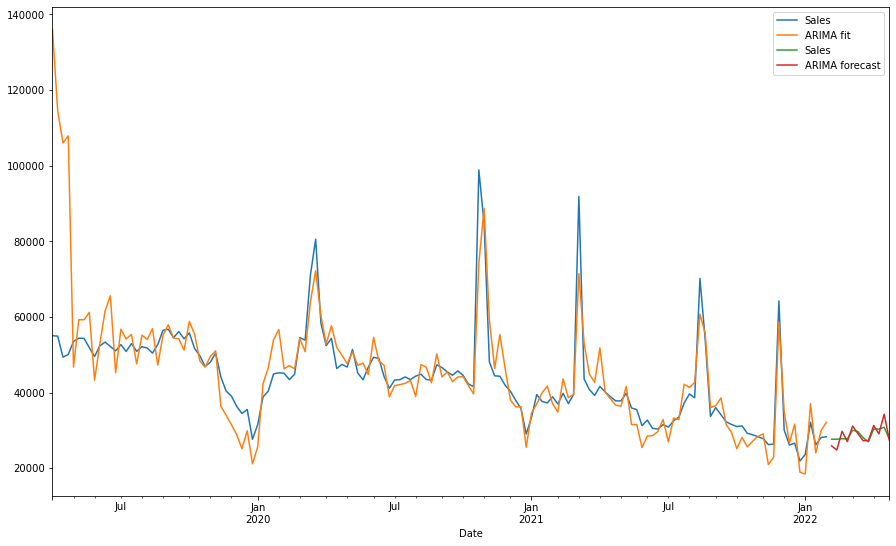

In [52]:
ax = train.Sales.plot(legend=True);
model.fittedvalues.rename("ARIMA fit").plot(ax=ax, legend=True)
test.Sales.plot(ax=ax, legend=True);
forecasts.rename("ARIMA forecast").plot(ax=ax, legend=True);

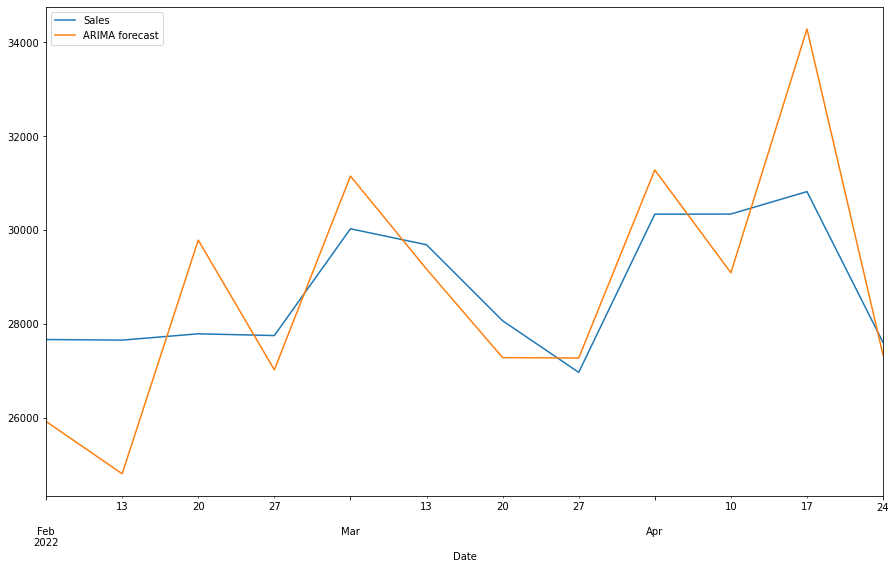

In [53]:
ax = test.Sales.plot(legend=True);
forecasts.rename("ARIMA forecast").plot(ax=ax, legend=True);